## Imbalanced Data: Binary Classification Problem

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split    
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix   
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

from sklearn.tree import DecisionTreeClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks


import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("Customer-Churn.csv")
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,Yes,No,No,No,No,Month-to-month,29.85,29.85,No
1,Male,0,No,No,34,Yes,Yes,No,Yes,No,No,No,One year,56.95,1889.5,No
2,Male,0,No,No,2,Yes,Yes,Yes,No,No,No,No,Month-to-month,53.85,108.15,Yes
3,Male,0,No,No,45,No,Yes,No,Yes,Yes,No,No,One year,42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,No,No,No,No,No,Month-to-month,70.70,151.65,Yes


In [4]:
data.shape

(7043, 16)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   OnlineSecurity    7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  StreamingTV       7043 non-null   object 
 11  StreamingMovies   7043 non-null   object 
 12  Contract          7043 non-null   object 
 13  MonthlyCharges    7043 non-null   float64
 14  TotalCharges      7043 non-null   object 
 15  Churn             7043 non-null   object 
dtypes: float64(1), int64(2), object(13)
memory

In [6]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

In [ ]:
#data['SeniorCitizen']=data['SeniorCitizen'].astype(str)

In [7]:
data.isna().sum().to_frame().rename(columns={0:'count'}).sort_values(by='count', ascending=False)

#TotalCharges column as 11 nulls.

,count
TotalCharges,11
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
OnlineSecurity,0
OnlineBackup,0
DeviceProtection,0


In [8]:
# Replace Nulls with mean
data['TotalCharges'].fillna(int(data['TotalCharges'].mean()), inplace=True)

# OR drop ROWS with nulls since it's only 11 rows.
#data = data.dropna()

### 1. Apply SMOTE for upsampling the data

Random creation of a fake sample. Compute the k-nearest neighbors (for some pre-specified k) for this point. If a k-nn predicts this fake sample to belong to the minority class, keep it, otherwise throw it away.



In [9]:
data.Churn.value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

We can see skewed class proportions. Majority class is "No" with 5174 values against only 1869 of "Yes" values. 
Our model will be biased towards the majority class if we use this imbalanced data!! It can be problematic especially when we are interested in the prediction of the minority class.

<AxesSubplot:xlabel='Churn', ylabel='count'>

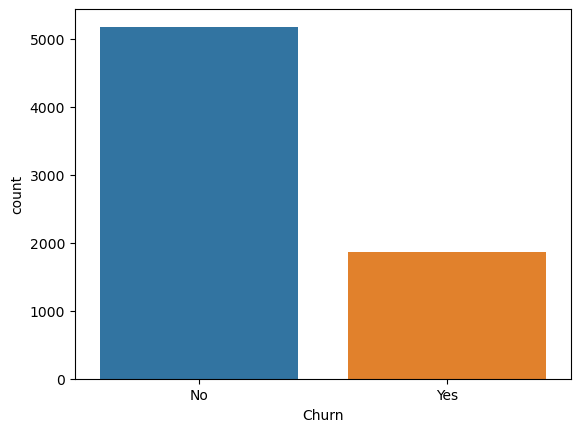

In [10]:
sns.countplot(data["Churn"])

In [11]:
# First, let's encode our categorical columns

data2 = pd.get_dummies(data, columns=['gender', 'Partner', 'Dependents', 'PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract'])
data2.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year
0,0,1,29.85,29.85,No,1,0,0,1,1,...,0,1,0,0,1,0,0,1,0,0
1,0,34,56.95,1889.50,No,0,1,1,0,1,...,0,1,0,0,1,0,0,0,1,0
2,0,2,53.85,108.15,Yes,0,1,1,0,1,...,0,1,0,0,1,0,0,1,0,0
3,0,45,42.30,1840.75,No,0,1,1,0,1,...,1,1,0,0,1,0,0,0,1,0
4,0,2,70.70,151.65,Yes,1,0,1,0,1,...,0,1,0,0,1,0,0,1,0,0


In [12]:
#... and normalize our numerical columns

numerical=data.select_dtypes(np.number)
numerical=numerical.drop("SeniorCitizen", axis=1)
numerical.head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


In [13]:
from sklearn.preprocessing import MinMaxScaler

transformer = MinMaxScaler().fit(numerical)
data_normalized = transformer.transform(numerical)
data_normalized = pd.DataFrame(data_normalized, columns=numerical.columns)
data_normalized.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,0.449599,0.462803,0.261309
std,0.341104,0.299403,0.261366
min,0.000000,0.000000,0.000000
25%,0.125000,0.171642,0.044245
50%,0.402778,0.518408,0.159445
75%,0.763889,0.712438,0.434780
max,1.000000,1.000000,1.000000


In [14]:
data2[['tenure','MonthlyCharges','TotalCharges']] = data_normalized[['tenure','MonthlyCharges','TotalCharges']]
data2.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,...,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,0.449599,0.462803,0.261309,0.495244,0.504756,0.516967,0.483033,0.700412,0.299588,...,0.290217,0.398978,0.216669,0.384353,0.395428,0.216669,0.387903,0.550192,0.209144,0.240664
std,0.368612,0.341104,0.299403,0.261366,0.500013,0.500013,0.499748,0.499748,0.458110,0.458110,...,0.453895,0.489723,0.412004,0.486477,0.488977,0.412004,0.487307,0.497510,0.406726,0.427517
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.125000,0.171642,0.044245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.402778,0.518408,0.159445,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.763889,0.712438,0.434780,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
X = data2.drop(["Churn"], axis = 1)
y = data2["Churn"]

#### Baseline Model before upsampling data with SMOTE.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)


In [26]:
def different_models(models):
    
    model = models
    model.fit(X_train,y_train) 
    #predictions
    predictions = model.predict(X_test)
    #metrics for evaluation
    print("The accuracy of the model is: {:4.2f}".format(model.score(X_test, y_test)*100))
    print(confusion_matrix(y_test, predictions)) 
    print(classification_report(y_test, predictions))
    plot_confusion_matrix(model, X_test, y_test)  
    plt.show()

The accuracy of the model is: 77.95
[[1358  189]
 [ 277  289]]
              precision    recall  f1-score   support

          No       0.83      0.88      0.85      1547
         Yes       0.60      0.51      0.55       566

    accuracy                           0.78      2113
   macro avg       0.72      0.69      0.70      2113
weighted avg       0.77      0.78      0.77      2113



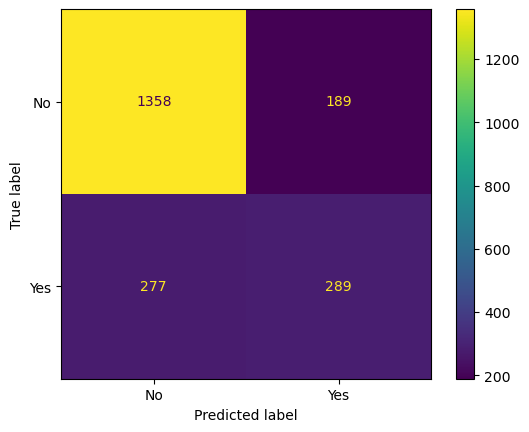

In [27]:
different_models(LogisticRegression(random_state=0, multi_class='ovr'))

Accuracy is 78%.
1358 True Negatives. 
289 True Positives. 
189 False Positives. 
277 False negatives (too many!)

Baseline Model is good at predicting True "No" but not so good in predicting True "Yes", which is expected because of the imbalance data.

In [28]:
smote = SMOTE()

X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()

No     5174
Yes    5174
Name: Churn, dtype: int64

#### 1.1 Use logistic regression to fit the model and compute the accuracy of the model.

The accuracy of the model is: 81.93
[[1243  314]
 [ 247 1301]]
              precision    recall  f1-score   support

          No       0.83      0.80      0.82      1557
         Yes       0.81      0.84      0.82      1548

    accuracy                           0.82      3105
   macro avg       0.82      0.82      0.82      3105
weighted avg       0.82      0.82      0.82      3105



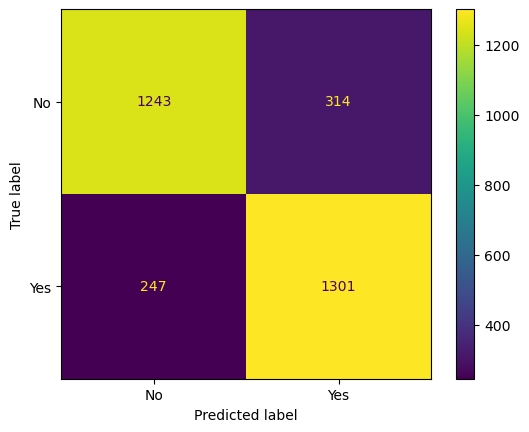

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=100)
different_models(LogisticRegression(random_state=0, multi_class='ovr'))

The accuracy of the model increased to 82%.

Precision of our model increased to 80% when predicting True "Yes" (True Positives) while it remains accurate (83%) in predicting  True "No" (True Negatives). Overall, better than our Baseline Model, using SMOTE technique to upsample our data in Logistic Regression.

#### 1.2 Use decision tree classifier to fit the model and compute the accuracy of the model.

The accuracy of the model is: 77.42
[[1213  344]
 [ 357 1191]]
              precision    recall  f1-score   support

          No       0.77      0.78      0.78      1557
         Yes       0.78      0.77      0.77      1548

    accuracy                           0.77      3105
   macro avg       0.77      0.77      0.77      3105
weighted avg       0.77      0.77      0.77      3105



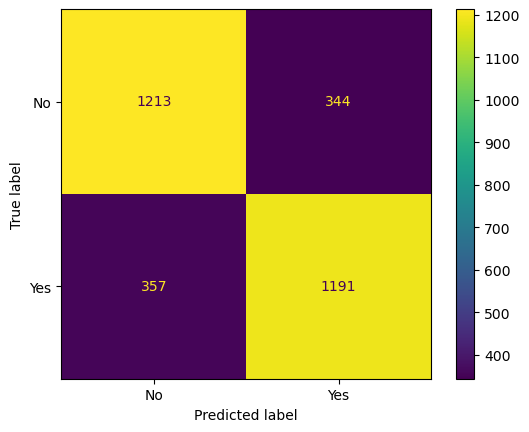

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=100)
different_models(DecisionTreeClassifier(criterion = "gini", random_state = 42, max_depth=None))

#Gini Index is a metric to measure how often a randomly chosen element would be incorrectly identified.
#It means an attribute with lower gini index should be preferred.

#### 1.3 Compare the accuracies of the two models.

Accuracy got worst with Decision Tree Classifier (77%) when comparing with Logistic Regression (82%), with oversampling using SMOTE.
In terms of precision, Logistic Regression is also better in predicting True Negatives and True Positives.

### 2.Apply TomekLinks for downsampling

Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process. It drops data, removes instances from majority class that could be minority.

It does not make the two classes equal but only removes the points from the majority class that are close to other points.

In [31]:
tl = TomekLinks(sampling_strategy='majority')
X_tl, y_tl = tl.fit_resample(X, y)
y_tl.value_counts()

No     4590
Yes    1869
Name: Churn, dtype: int64

In [32]:
y.value_counts()

# 584 values removed from majority class ("No")

No     5174
Yes    1869
Name: Churn, dtype: int64

#### 2.1 Use logistic regression to fit the model and compute the accuracy of the model.

The accuracy of the model is: 81.68
[[1250  145]
 [ 210  333]]
              precision    recall  f1-score   support

          No       0.86      0.90      0.88      1395
         Yes       0.70      0.61      0.65       543

    accuracy                           0.82      1938
   macro avg       0.78      0.75      0.76      1938
weighted avg       0.81      0.82      0.81      1938



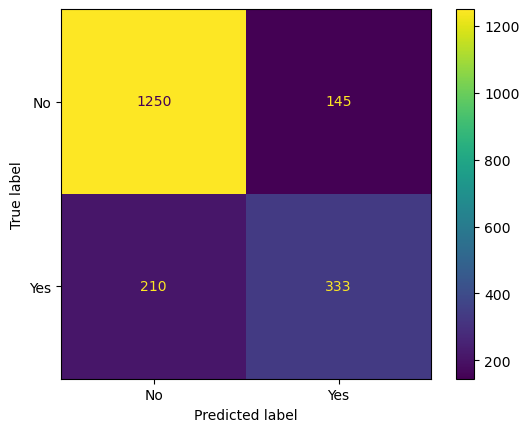

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_tl, y_tl, test_size=0.3, random_state=100)
different_models(LogisticRegression(random_state=0, multi_class='ovr'))

#### 2.2 Use decision tree classifier to fit the model and compute the accuracy of the model.

The accuracy of the model is: 75.90
[[1162  233]
 [ 234  309]]
              precision    recall  f1-score   support

          No       0.83      0.83      0.83      1395
         Yes       0.57      0.57      0.57       543

    accuracy                           0.76      1938
   macro avg       0.70      0.70      0.70      1938
weighted avg       0.76      0.76      0.76      1938



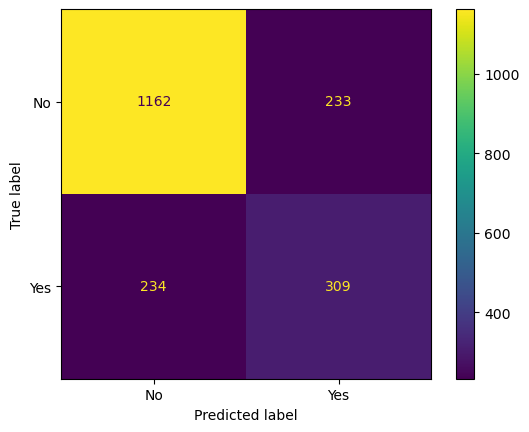

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_tl, y_tl, test_size=0.3, random_state=100)
different_models(DecisionTreeClassifier(criterion = "gini", random_state = 42, max_depth=None))

#Gini Index is a metric to measure how often a randomly chosen element would be incorrectly identified.
#It means an attribute with lower gini index should be preferred.

#### 2.3 Compare the accuracies of the two models.



**SMOTE**
<br>
<br>
*Logistic Regression:*
<br>

Accuracy 82%
<br>
Precision True Negatives 83% 
<br>
Precision True Positives 81%.
<br>
<br>
*Decision Tree Classifier:*
<br>

Accuracy 77.5% 
<br>
Precision True Negatives 77%
<br>
Precision True Positives 78%.
<br>
<br>
**TomekLinks**
<br>
<br>
*Logistic Regression:*
<br>

Accuracy 82% 
<br>
Precision True Negatives 86%
<br>
Precision True Positives 70%
<br>
<br>
*Decision Tree Classifier:*
<br>

Accuracy 76% 
<br>
Precision True Negatives 83%
<br>
Precision True Positives 57%
<br>
<br>
**Conclusion**
<br>

**Logistic Regression with SMOTE technique** to oversample the minority class is the best model in predicting True Negative values but also True Positive values which are equally important, with an accuracy of 82%.